In [1]:
# Import necessary libraries
import os
from IPython.display import Audio
import librosa
import numpy as np
import random
import pandas as pd

# Visualization libraries
import seaborn as sns
from librosa.effects import feature
import librosa.display as disp
import matplotlib.pyplot as plt
from numpy.ma.core import size
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from matplotlib.cbook import flatten

# Audio processing and playback
from IPython.display import Audio

# Deep learning libraries
import keras
from keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Dense, TimeDistributed, Conv1D, LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


In [2]:
# Define the path to the dataset
path = r'C:\Users\96650\Desktop\project dp\emotion'

# Function to load data from the specified path
def load_data(path):
    # Lists to store emotions and file paths
    f_emotions = []
    f_pathes = []
    
    # Get the list of folders in the specified path
    folders = os.listdir(path)

    # Loop through each folder
    for folder in folders:
        # Get the list of files in the current folder
        files = os.listdir(path + '/' + folder)
        
        # Loop through each file in the folder
        for file in files:
            # Extract emotion label from the file name
            step = file.split('.')[0]
            step = step.split('-')[2]
            
            # Append emotion label and file path to the respective lists
            f_emotions.append(int(step))
            f_pathes.append(path + '/'  + folder + os.sep + file)

    # Return the lists containing emotions and file paths
    return [f_emotions, f_pathes]

# Function to get the corresponding emotion label based on a given number
def get_emotion(number):
    # Dictionary mapping emotion numbers to labels
    info = {1: 'neutral',
            2: 'calm',
            3: 'happy',
            4: 'sad',
            5: 'angry',
            6: 'fear',
            7: 'disgust',
            8: 'surprise'}
    
    # Return the emotion label for the given number
    return info[number]

# Load data from the specified path and store emotions and file paths
emotions, pathes = load_data(path)


In [3]:

# Function to read audio file
def read_audio(path):
    # Load audio file with a duration of 2.4 seconds starting from 0.6 seconds offset
    data, sample_rate = librosa.load(path, duration=2.4, offset=0.6)
    return data, sample_rate

# Function to draw the audio waveform
def draw_wave(path, data, sr):
    # Create a plot for the audio waveform
    plt.figure(figsize=(10, 4))
    plt.title('Audio Waveform: ' + path, size=12)
    
    # Display the waveform
    disp.waveshow(data, sr=sr)
    
    # Show the plot
    plt.show()

# Function to draw the spectrogram
def draw_spectrogram(path, data, sr):
    # Create a plot for the spectrogram
    plt.figure(figsize=(10, 4))
    
    # Compute the short-time Fourier transform (STFT) of the audio data
    X = librosa.stft(data)
    
    # Convert amplitude to decibels for better visualization
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Set title for the spectrogram plot
    plt.title('Spectrogram for Audio Waveform: ' + path, size=17)
    
    # Display the spectrogram
    disp.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    
    # Show the plot
    plt.show()

In [4]:
# Function to add noise to audio data
def add_noise(data, sr):
    # Calculate the maximum value in the data
    max_value = np.max(data)
    
    # Generate random noise with amplitude 0.035 times the maximum data value
    noise = 0.035 * np.random.uniform() * max_value
    
    # Add the generated noise to the audio data
    data += noise * np.random.normal(size=data.shape[0])
    
    # Return the modified audio data and the sample rate
    return data, sr

In [5]:

# Function to apply random shift to audio data
def shift(data, sr):
    # Generate a random shift value in the range of -5 to 5 milliseconds
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    
    # Shift the audio data by the generated value
    shifted = np.roll(data, shift_range)
    
    # Return the shifted audio data and the sample rate
    return shifted, sr


In [6]:

# Function to apply pitch shift to audio data
def pitch(data, sr, factor=0.6):
    # Use librosa to apply pitch shift to the audio data
    pitched = librosa.effects.pitch_shift(y=data, sr=sr, n_steps=factor)
    
    # Return the pitched audio data and the sample rate
    return pitched, sr


In [7]:

# Function to apply time stretch to audio data
def stretch(data, sr, rate=0.85):
    # Use librosa to apply time stretch to the audio data
    stretched = librosa.effects.time_stretch(y=data, rate=rate)
    
    # Return the stretched audio data and the sample rate
    return stretched, sr


In [8]:


# Function to extract Mel-frequency cepstral coefficients (MFCCs) from audio data
def feature_extraction(data, sr):
    # Use librosa to extract MFCCs from the audio data
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    
    # Return the extracted MFCCs
    return mfcc

# Function to process audio data based on a randomly selected option
def processing_audio(data, sr, options):
    # Randomly choose a processing option from the provided list
    func = random.choice(options)
    
    # If the chosen option is 'Standard', return the original data
    if func == 'Standard':
        processed = data
    else:
        # Otherwise, apply the chosen processing function to the data
        processed, _ = func(data, sr)
    
    # Return the processed audio data
    return processed


In [9]:
# Function to get features from audio file
def get_features(path):
    # Read audio data from the specified path
    data, sample_rate = read_audio(path)

    # List of processing functions including 'Standard', add_noise, and pitch
    functions = ['Standard', add_noise, pitch]
    
    # List to store extracted features
    features = []

    # Apply processing and feature extraction multiple times
    for _ in range(3):
        # Apply random processing functions to the data
        func1_data = processing_audio(data, sample_rate, functions)
        func2_data = processing_audio(func1_data, sample_rate, functions)

        # Extract features from the processed data
        feature = feature_extraction(func2_data, sample_rate)
        
        # Check if the extracted feature has the expected shape (20, 104)
        if feature.shape == (20, 104):
            # Append the feature to the list of features
            features.append(feature)

    # Return the list of extracted features
    return features


20
calm


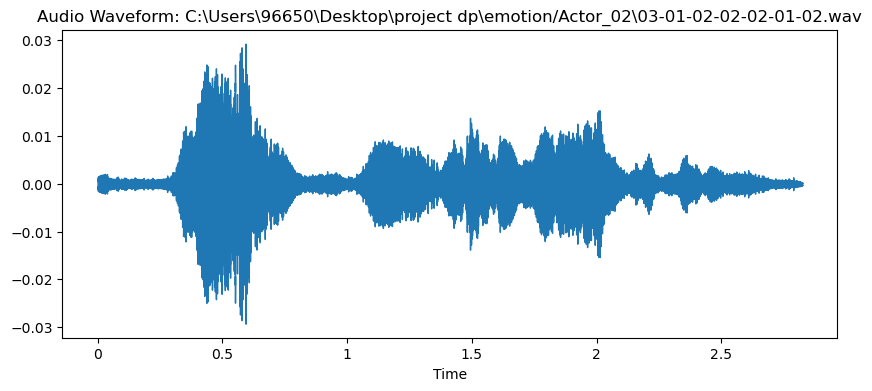

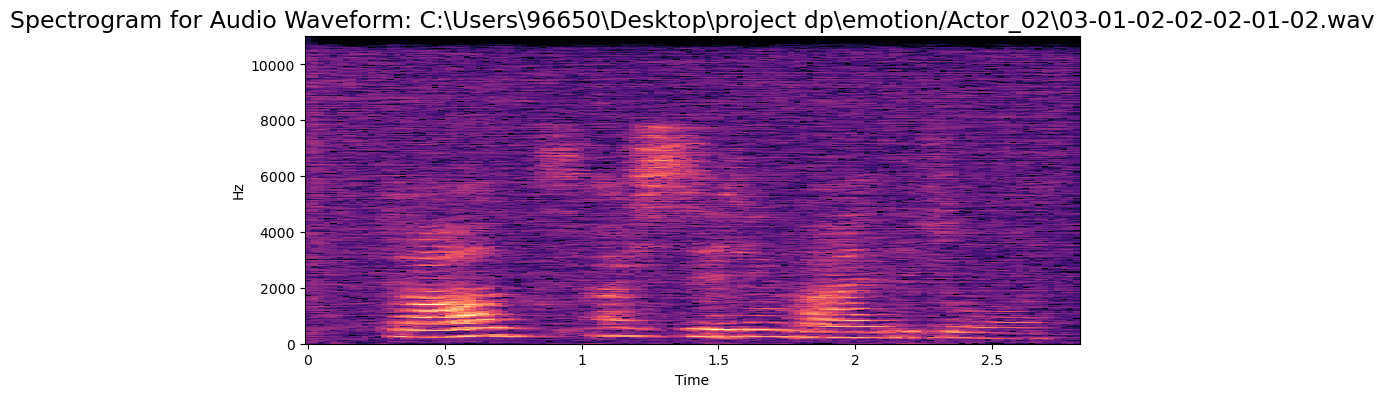

In [10]:
# Function to display audio information and visualizations
def display(number):
    # Read audio data and sample rate from the specified file
    data, sample_rate = read_audio(pathes[number])

    # Extract MFCC features from the audio data
    mfcc_features = feature_extraction(data, sample_rate)

    # Print the number of MFCC features extracted
    print(len(mfcc_features))

    # Print the emotion label corresponding to the given number
    print(get_emotion(emotions[number]))

    # Apply various audio processing techniques
    data, sample_rate = add_noise(data, sample_rate)
    data, sample_rate = shift(data, sample_rate)
    data, sample_rate = pitch(data, sample_rate)
    data, sample_rate = stretch(data, sample_rate)

    # Display the audio waveform and spectrogram
    draw_wave(pathes[number], data, sample_rate)
    draw_spectrogram(pathes[number], data, sample_rate)

    # Return the modified audio data and sample rate
    return data, sample_rate

# Example usage of the display function for file at index 70
d, sr = display(70)

# Play the modified audio using IPython Audio
Audio(data=d, rate=sr)


In [11]:
X = []  # List to store features
Y = []  # List to store one-hot encoded emotion labels

# Loop through each audio file path
for indx in range(len(pathes)):
    # Get features from the audio file at the current index
    value = get_features(pathes[indx])

    # Check if features are extracted (not an empty list)
    if value != []:
        # Loop through each set of features
        for item in value:
            # Append features to X
            X.append(item)

            # One-hot encode the emotion label and append to Y
            Y.append(np.eye(8)[emotions[indx] - 1])


In [12]:

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the input array (reshape for compatibility)
encoded_array = encoder.fit_transform(np.array([1, 2, 3, 4, 1, 5, 6, 7, 8]).reshape(-1, 1)).toarray()

# Display the result
print(encoded_array)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [13]:
# Retrieve the first element (feature set) from the lis
X[0]


array([[-5.0804111e+02, -4.7411868e+02, -4.7100439e+02, ...,
        -4.7421011e+02, -4.7493933e+02, -4.9079480e+02],
       [-6.5136356e+00, -4.9885902e+00, -3.6296990e+00, ...,
        -7.5736160e+00, -5.3074207e+00, -4.7729530e+00],
       [ 7.2712672e-01, -3.1290026e+00, -2.3615153e+00, ...,
        -1.4960783e+00,  1.6895466e+00, -5.1101762e-01],
       ...,
       [-4.5579395e+00, -3.5702357e+00,  5.8258158e-01, ...,
         6.0027857e+00,  7.1942735e-01, -2.3393553e-01],
       [-5.3572326e+00, -2.9494271e+00,  2.1732242e+00, ...,
         4.4294500e+00,  3.6337652e+00, -1.3642182e+00],
       [ 2.2913697e+00,  8.2702780e-01,  1.6270638e+00, ...,
        -2.0852666e+00, -1.9064691e+00, -2.3993595e+00]], dtype=float32)

In [14]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    np.array(X),  # Features (input data)
    np.array(Y),  # Labels (output data)
    test_size=0.2,  # Percentage of data to use for testing
    random_state=11,  # Seed for random number generation (for reproducibility)
    shuffle=True  # Shuffle the data before splitting
)

# Print the shapes of the resulting training and testing sets
print('Train X shape:', x_train.shape)
print('Test X shape:', x_test.shape)
print('Test Y shape:', y_test.shape)
print('Train Y shape:', y_train.shape)

Train X shape: (3451, 20, 104)
Test X shape: (863, 20, 104)
Test Y shape: (863, 8)
Train Y shape: (3451, 8)


In [15]:
# Ensure the data is compatible with the model

# Expand dimensions for the training data
trainX = np.expand_dims(x_train, axis=3)
# Add an additional dimension to match the model requirements
trainX = np.expand_dims(trainX, axis=3)
# Swap axes to rearrange dimensions
trainX = np.swapaxes(trainX, 1, 2)
print('trainX:', trainX.shape)

# Expand dimensions for the testing data
testX = np.expand_dims(x_test, axis=3)
# Add an additional dimension to match the model requirements
testX = np.expand_dims(testX, axis=3)
# Swap axes to rearrange dimensions
testX = np.swapaxes(testX, 1, 2)
print('testX:', testX.shape)

# Get the input shape for the model
inputShape = trainX.shape[1:]
inputShape


trainX: (3451, 104, 20, 1, 1)
testX: (863, 104, 20, 1, 1)


(104, 20, 1, 1)

In [16]:
# Function to create the model
def create_model(inputShape):
    # Create a sequential model
    model = Sequential()

    # TimeDistributed layer with 1D convolutional layer, batch normalization, and activation
    model.add(TimeDistributed(Conv1D(32, 3, padding='same', activation='relu'), input_shape=inputShape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))  # Flatten the output of Conv1D for each time step

    # Long Short-Term Memory (LSTM) layer
    model.add(LSTM(64))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

    # Fully connected layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))

    # Output layer with 8 units for the 8 emotion classes and softmax activation
    model.add(Dense(units=8, activation='softmax'))

    return model


In [17]:
# Create the model using the specified input shape
model = create_model(inputShape)

# Display a summary of the model architecture
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 104, 20, 1, 32)    128       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 104, 20, 1, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 104, 640)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                180480    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

In [18]:
from pickle import STOP
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.6, verbose=1, patience=5, min_lr=1e-8)
stop = EarlyStopping(monitor='val_loss', patience=7)
hist = model.fit(trainX, y_train, batch_size=140, epochs=100, validation_data=(testX, y_test), callbacks=[reduce, stop])

Epoch 1/100


25/25 [==============================] - 6s 150ms/step - loss: 2.0171 - accuracy: 0.1907 - val_loss: 1.9919 - val_accuracy: 0.2260 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 3s 125ms/step - loss: 1.8731 - accuracy: 0.2741 - val_loss: 1.9006 - val_accuracy: 0.2665 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 3s 134ms/step - loss: 1.7932 - accuracy: 0.2993 - val_loss: 1.8232 - val_accuracy: 0.3152 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 3s 132ms/step - loss: 1.7198 - accuracy: 0.3361 - val_loss: 1.7042 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 4s 140ms/step - loss: 1.6885 - accuracy: 0.3567 - val_loss: 1.6394 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 3s 138ms/step - loss: 1.6300 - accuracy: 0.3657 - val_loss: 1.6017 - val_accuracy: 0.3824 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 3s 127ms/

Epoch 49/100
25/25 [==============================] - 3s 124ms/step - loss: 0.4120 - accuracy: 0.8571 - val_loss: 0.7130 - val_accuracy: 0.7474 - lr: 6.0000e-04
Epoch 50/100
25/25 [==============================] - 3s 129ms/step - loss: 0.3974 - accuracy: 0.8655 - val_loss: 0.6853 - val_accuracy: 0.7578 - lr: 6.0000e-04
Epoch 51/100
25/25 [==============================] - 3s 125ms/step - loss: 0.3691 - accuracy: 0.8716 - val_loss: 0.7376 - val_accuracy: 0.7462 - lr: 6.0000e-04
Epoch 52/100
25/25 [==============================] - 3s 128ms/step - loss: 0.3736 - accuracy: 0.8725 - val_loss: 0.7938 - val_accuracy: 0.7439 - lr: 6.0000e-04
Epoch 53/100
25/25 [==============================] - 3s 128ms/step - loss: 0.3826 - accuracy: 0.8661 - val_loss: 0.7004 - val_accuracy: 0.7590 - lr: 6.0000e-04
Epoch 54/100
25/25 [==============================] - 3s 125ms/step - loss: 0.3234 - accuracy: 0.8861 - val_loss: 0.7203 - val_accuracy: 0.7671 - lr: 6.0000e-04
Epoch 55/100
25/25 [==============

In [19]:
print(model.evaluate(testX,y_test)[1]*100,'%')


27/27 [==============================] - 0s 12ms/step - loss: 0.6521 - accuracy: 0.8007
80.06952404975891 %


Text(0, 0.5, 'accuracy')

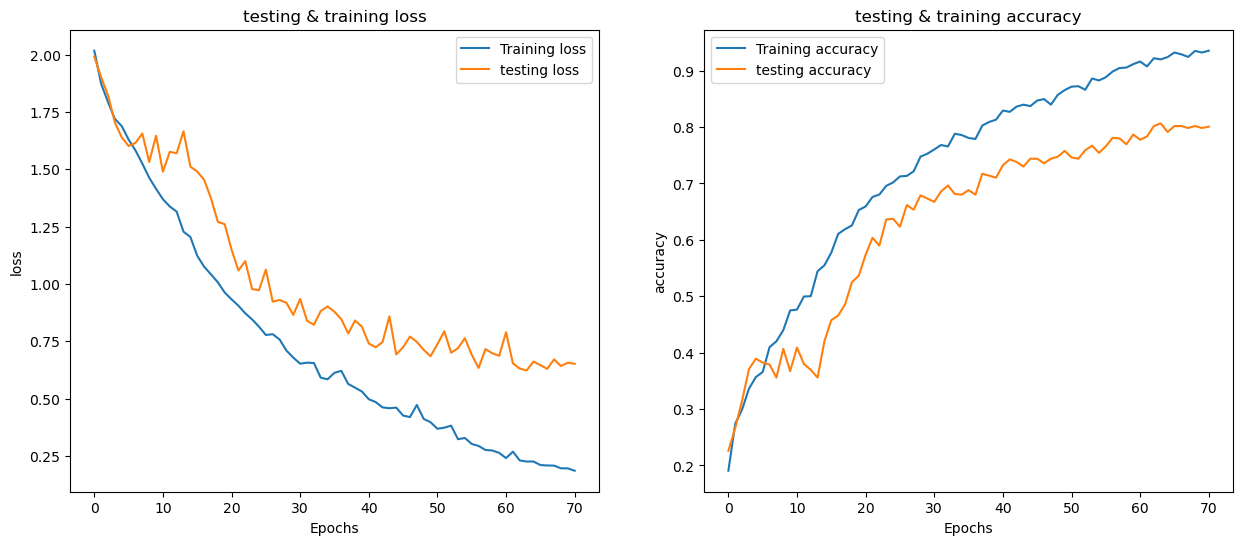

In [21]:
train_loss=hist.history['loss']
test_loss=hist.history['val_loss']
train_accuracy=hist.history['accuracy']
test_accuracy=hist.history['val_accuracy']
epochs=[value for value in range(71)]

fig , ax=plt.subplots(1,2)

ax[0].plot(epochs,train_loss , label='Training loss')
fig.set_size_inches(15,6)
ax[0].plot(epochs,test_loss , label='testing loss')
ax[0].set_title ('testing & training loss')
ax[0]. legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')

ax[1].plot(epochs,train_accuracy , label='Training accuracy')
ax[1].plot(epochs,test_accuracy , label='testing accuracy')
ax[1].set_title ('testing & training accuracy')
ax[1]. legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')

In [22]:
model.save(r'C:\Users\96650\Desktop\project dp\model3_model.keras')


In [23]:
emotion_model = load_model(r'C:\Users\96650\Desktop\project dp\model3_model.keras')
#y predict emotion
y_pred= emotion_model.predict(testX)

27/27 [==============================] - 1s 12ms/step


In [24]:
# Inverse transform the predicted and actual labels to get the original emotion labels
predY = encoder.inverse_transform(y_pred)
testY = encoder.inverse_transform(y_test)

# Convert the flattened arrays to lists of emotion labels
emotions_predict = [get_emotion(value) for value in predY.flatten()]
emotions_actual = [get_emotion(value) for value in testY.flatten()]

# Create a DataFrame to compare actual and predicted emotions
df = pd.DataFrame(columns=['Actual Emotions', 'Predicted Emotions'])
df['Actual Emotions'] = emotions_actual
df['Predicted Emotions'] = emotions_predict

# Display the first 20 rows of the DataFrame
df.head(20)


,Actual Emotions,Predicted Emotions
0,surprise,angry
1,calm,calm
2,fear,fear
3,neutral,neutral
4,sad,surprise
5,neutral,neutral
6,happy,sad
7,calm,calm
8,sad,sad
9,sad,sad


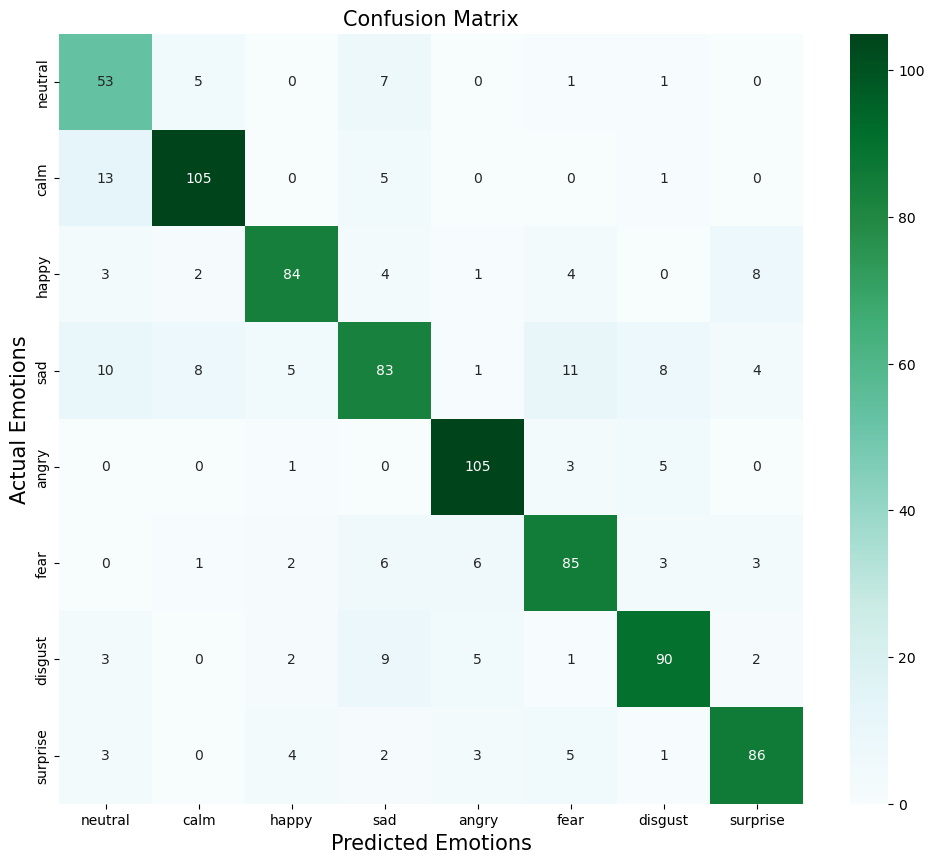

Classification Report:
               precision    recall  f1-score   support

     neutral       0.62      0.79      0.70        67
        calm       0.87      0.85      0.86       124
       happy       0.86      0.79      0.82       106
         sad       0.72      0.64      0.67       130
       angry       0.87      0.92      0.89       114
        fear       0.77      0.80      0.79       106
     disgust       0.83      0.80      0.81       112
    surprise       0.83      0.83      0.83       104

    accuracy                           0.80       863
   macro avg       0.80      0.80      0.80       863
weighted avg       0.80      0.80      0.80       863



In [25]:
from sklearn.metrics import classification_report

# ...

# Calculate the confusion matrix
cm = confusion_matrix(testY, predY)

# Get emotion labels from the encoder categories
emotions = [get_emotion(em) for em in encoder.categories_[0]]

# Create a DataFrame for the confusion matrix with emotion labels as index and columns
cmt = pd.DataFrame(cm, index=emotions, columns=emotions)

# Calculate the classification report
classification_rep = classification_report(testY, predY, target_names=emotions)

# Set up the size of the heatmap
plt.figure(figsize=(12, 10))

# Plot the confusion matrix as a heatmap using seaborn
sns.heatmap(cmt, annot=True, fmt='', cmap='BuGn')

# Set plot title and axis labels
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Emotions', size=15)
plt.ylabel('Actual Emotions', size=15)

# Display the heatmap
plt.show()

# Display the classification report
print("Classification Report:\n", classification_rep)
